In [1]:
print("Importing...")

import sys
import os
from os import mkdir
from os.path import join
from os.path import isdir
from os.path import isfile
from os.path import abspath
from shutil import rmtree

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

from tensorflow import keras
import tensorflow_addons as tfa

sys.path.insert(0, "../scs")
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
from prepare_datasets_for_training import extract
from learn import compile_model, get_callbacks, train, evaluate
from lr_schedules import get_lr_schedule
import data_plotting as dplt
import scs_config as scsc

sys.path.insert(0, "../scs/models")
import feed_forward
import transformer_encoder
import dash

from importlib import reload

Importing...


2023-07-28 18:03:08.337063: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
hp = {
    "lr0": 0.00001,
    "lr_schedule": "constant_lr",
    "epochs": 10_000,
    "batch_size": 32,
}

In [3]:
R = 100
data_dir_degraded = "/lustre/lrspec/users/2649/spectralib"
data_dir_degraded_R = join(data_dir_degraded, f"{R}")

dir_model = "/lustre/lrspec/users/2649/models/FF"
dir_backup = join(dir_model, "backup")
dir_model_data = join(dir_model, "data")

if isdir(dir_model):
    rmtree(dir_model)

if not isdir(dir_model):
    mkdir(dir_model)
    mkdir(dir_backup)
    mkdir(dir_model_data)
    
use_rebinned_data = False

In [4]:
# Get names of files containing the fully prepared data.
file_trn = join(data_dir_degraded_R, "sn_data_trn.CPA.parquet")
file_tst = join(data_dir_degraded_R, "sn_data_tst.CP.parquet")
if use_rebinned_data:
    file_trn = join(data_dir_degraded_R, "sn_data_trn.RPA.parquet")
    file_tst = join(data_dir_degraded_R, "sn_data_tst.RP.parquet")

In [5]:
# Load the dataset.
df_trn = pd.read_parquet(file_trn)
df_tst = pd.read_parquet(file_tst)

Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_trn)
Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_tst)

In [6]:
Xtrn.shape, Ytrn.shape, num_trn, num_wvl, num_classes

((21657, 1024), (21657, 16), 21657, 1024, 16)

In [7]:
Xtst.shape, Ytst.shape, num_tst, num_wvl, num_classes

((1416, 1024), (1416, 16), 1416, 1024, 16)

In [8]:
input_shape = Xtrn.shape[1:]
assert input_shape == (1024,)

model = feed_forward.model(input_shape, num_classes, [128, 128, 128], dropout=0.25)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

2023-07-28 18:03:16.452894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 18:03:18.029393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2023-07-28 18:03:18.031245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30988 MB memory:  -> device: 1, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2023-07-28 18:03:18.033049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job

In [9]:
compile_model(model, num_classes, hp["lr0"])
lr_schedule = get_lr_schedule(hp)
callbacks = get_callbacks(dir_model, lr_schedule)

In [10]:
history = train(
    model,
    Xtrn,
    Ytrn,
    Xtst,
    Ytst,
    hp["epochs"],
    hp["batch_size"],
    callbacks,
)

Epoch 1/10000

Epoch 1: val_loss improved from inf to 2.62970, saving model to /lustre/lrspec/users/2649/models/FF/model.hdf5
677/677 - 7s - loss: 2.7679 - ca: 0.1156 - f1: 0.0991 - val_loss: 2.6297 - val_ca: 0.1194 - val_f1: 0.0837 - lr: 1.0000e-05 - 7s/epoch - 10ms/step
Epoch 2/10000

Epoch 2: val_loss improved from 2.62970 to 2.30427, saving model to /lustre/lrspec/users/2649/models/FF/model.hdf5
677/677 - 5s - loss: 2.3949 - ca: 0.2609 - f1: 0.2393 - val_loss: 2.3043 - val_ca: 0.4082 - val_f1: 0.2466 - lr: 1.0000e-05 - 5s/epoch - 8ms/step
Epoch 3/10000

Epoch 3: val_loss improved from 2.30427 to 2.00281, saving model to /lustre/lrspec/users/2649/models/FF/model.hdf5
677/677 - 5s - loss: 2.0889 - ca: 0.3854 - f1: 0.3646 - val_loss: 2.0028 - val_ca: 0.4944 - val_f1: 0.3053 - lr: 1.0000e-05 - 5s/epoch - 8ms/step
Epoch 4/10000

Epoch 4: val_loss improved from 2.00281 to 1.73389, saving model to /lustre/lrspec/users/2649/models/FF/model.hdf5
677/677 - 5s - loss: 1.8256 - ca: 0.4676 - f1

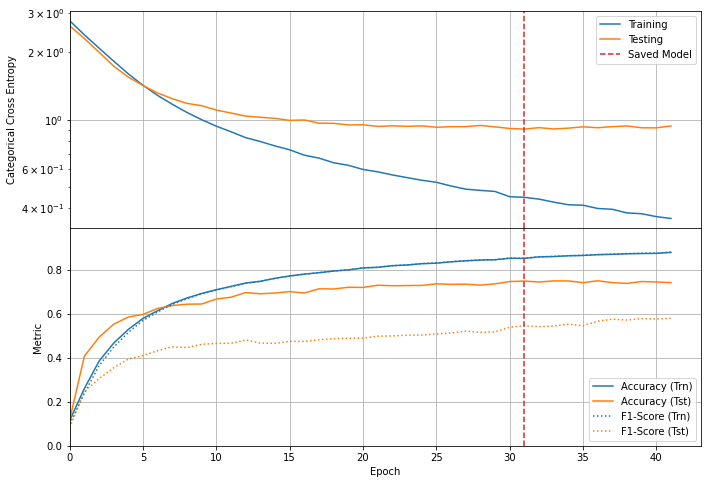

In [11]:
file_model_history = join(dir_model, "history.log")
log = pd.read_csv(file_model_history)
fig = dplt.plot_loss(log)
fig.show()

In [12]:
results = evaluate(model, Xtrn, Ytrn, Xtst, Ytst, verbose=0)
results

{'trn': {'loss': 0.24067792296409607,
  'ca': 0.926628828048706,
  'f1': 0.9266076683998108},
 'tst': {'loss': 0.906278133392334, 'ca': 0.75, 'f1': 0.5469483733177185}}

In [13]:
Ptst = model.predict(Xtst)
Ptst = np.argmax(Ptst, axis=1)

45/45 [==============================] - 0s 2ms/step


In [14]:
Ytst_non_OH = np.argmax(Ytst, axis=1)

In [15]:
SNtypes_int = np.unique(Ytst_non_OH)
SNtypes_str = [scsc.SN_Stypes_int_to_str[sn] for sn in SNtypes_int]
SNtypes_str, SNtypes_int, len(SNtypes_int), num_classes

(['Ia-norm',
  'Ia-91T',
  'Ia-91bg',
  'Ia-csm',
  'Iax',
  'Ia-pec',
  'Ib-norm',
  'Ibn',
  'IIb',
  'Ib-pec',
  'Ic-norm',
  'Ic-broad',
  'Ic-pec',
  'IIP',
  'IIL',
  'IIn'],
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 16,
 16)

In [16]:
CMtst = confusion_matrix(Ytst_non_OH, Ptst)

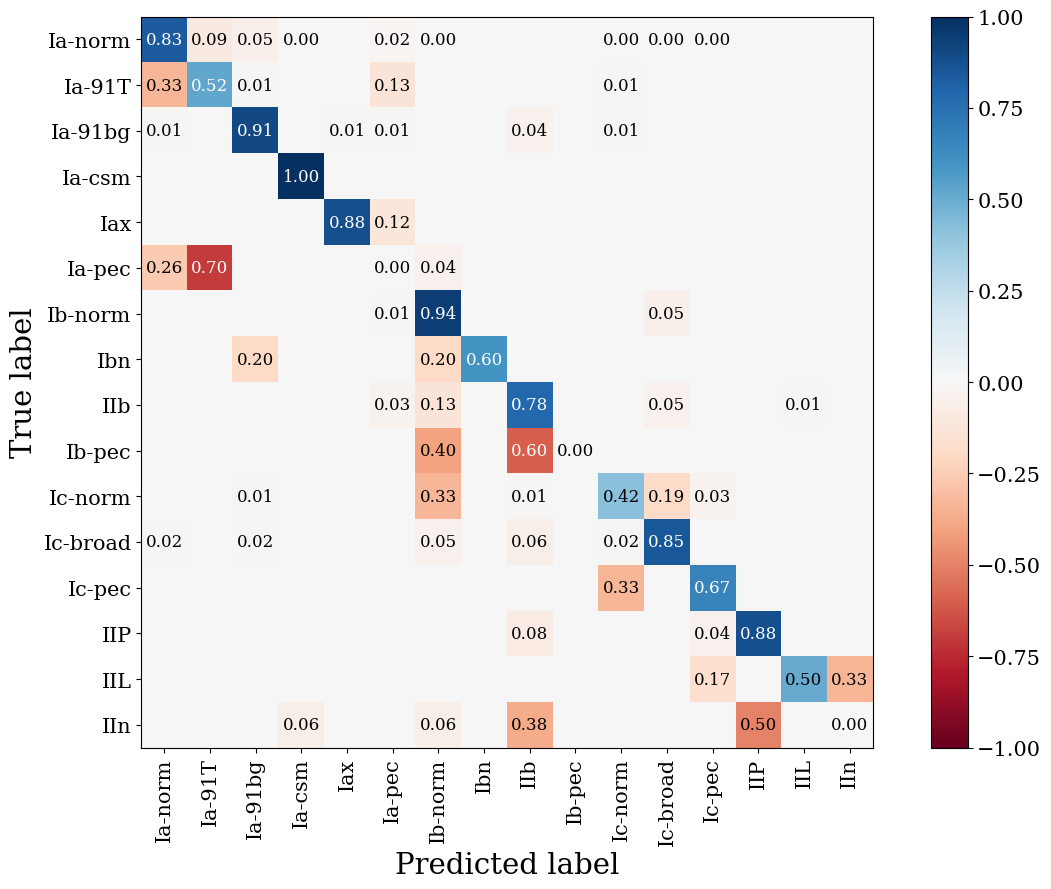

In [18]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.weight'] = "normal"


def plot_cm(
    cm,
    classes,
    R,
    normalize=True,
    figsize=(12, 9),
    fontsize_offset=5,
):

    """Normalize confusion matrix and set image parameters"""
    cm = cm.astype("float") / np.nansum(cm, axis=1)[:, np.newaxis]
    off_diag = ~np.eye(cm.shape[0], dtype=bool)
    cm[off_diag] *= -1
    vmin, vmax = -1, 1
    cmap = "RdBu"

    fig = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="None", cmap=cmap, vmin=vmin, vmax=vmax)

    # plt.title(f"R = {R}")

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        if (cm[i, j] == 0) and (i != j):
            continue
        
        plt.text(
            j,
            i,
            format(abs(cm[i, j]), fmt),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if abs(cm[i, j]) > thresh else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel("True label", fontsize=26 - fontsize_offset)
    plt.xlabel("Predicted label", fontsize=26 - fontsize_offset)
    plt.tight_layout()
    
    return fig


fig = plot_cm(CMtst, SNtypes_str, R, normalize=True)
fig.savefig("cm_ff.pdf")
fig.show()